In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


# --- KONFIGURASI GPU ---
# Kode ini mencegah GPU langsung memakan 100% VRAM saat inisialisasi
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Konfigurasi Seed agar hasil bisa direproduksi
print("Versi TF:", tf.__version__) # Harus 2.10.x
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Nama Device:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.random.set_seed(42)
np.random.seed(42)

Versi TF: 2.20.0
GPU Available: False
Nama Device: []
Num GPUs Available:  0


In [39]:
# Path Dataset (Sesuaikan dengan folder lokal Anda)
# Dataset harus memiliki struktur:
# DATA_DIR/
#   train/
#     normal/
#     benign/
#     malignant/
#   validation/
#     normal/
#     benign/
#     malignant/
#   test/
#     normal/
#     benign/
#     malignant/
#   masking/
#     training/         (untuk train split)
#       masking-normal/
#       masking-benign/
#       masking-malignant/ (atau masking-maglinant jika ada typo)
#     validation/       (untuk validation split)
#       masking-normal/
#       masking-benign/
#       masking-malignant/
#     test/             (untuk test split)
#       masking-normal/
#       masking-benign/
#       masking-malignant/
DATA_DIR = "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameter Gambar
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16  # Kurangi jika VRAM GPU < 4GB

# Hyperparameter Optimal (dari Paper)
LEARNING_RATE = 0.000506
NEURONS_FLN = 471
DROPOUT_RATE = 0.44
EPOCHS = 30      # Ditambah untuk training yang lebih baik
NUM_CLASSES = 3  # Benign, Malignant, Normal

In [40]:
# ---------- ROI Mask + CLAHE Preprocessing Function ----------
from pathlib import Path

def apply_clahe_and_roi_masking(img, generator_config=None):
    """
    Apply CLAHE + ROI mask to image if available, then apply DenseNet preprocessing.
    
    Args:
        img: numpy array (H, W, C) - original image loaded by ImageDataGenerator
        generator_config: dict with 'data_dir', 'split', 'class_name', 'filename'
    
    Returns:
        Preprocessed image ready for DenseNet201
    """
    # Pastikan tipe data uint8
    img = img.astype('uint8')
    
    # 1. Apply CLAHE first
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # 2. Apply ROI Masking if config provided
    if generator_config is not None:
        try:
            # Extract info
            data_dir = generator_config.get('data_dir', DATA_DIR)
            split = generator_config.get('split', 'train')  # train/validation/test
            class_name = generator_config.get('class_name', '')
            filename = generator_config.get('filename', '')
            
            # Map split names: train->training, validation->validation, test->test
            mask_split_map = {
                'train': 'training',
                'validation': 'validation', 
                'test': 'test'
            }
            mask_split = mask_split_map.get(split, split)
            
            # Build mask path: DATA_DIR/masking/{mask_split}/masking-{class_name}/{filename}_mask.png
            # e.g., benign (201).png -> benign (201)_mask.png
            base_name = Path(filename).stem  # Remove .png extension
            mask_filename = f"{base_name}_mask.png"
            
            # Try standard path first
            mask_path = os.path.join(data_dir, 'masking', mask_split, f'masking-{class_name}', mask_filename)
            
            # If not found and class is malignant, try with typo 'maglinant'
            if not os.path.exists(mask_path) and class_name == 'malignant':
                mask_path_typo = os.path.join(data_dir, 'masking', mask_split, 'masking-maglinant', mask_filename)
                if os.path.exists(mask_path_typo):
                    mask_path = mask_path_typo
            
            # Try to load mask
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if mask is not None:
                    # Resize mask to match image size
                    mask_resized = cv2.resize(mask, (img_clahe.shape[1], img_clahe.shape[0]))
                    
                    # Normalize mask to 0-1 range
                    mask_normalized = mask_resized.astype(np.float32) / 255.0
                    
                    # Expand dims for broadcasting (H, W) -> (H, W, 1)
                    mask_expanded = np.expand_dims(mask_normalized, axis=-1)
                    
                    # Apply mask: multiply image by mask (keeps ROI, blacks out background)
                    img_masked = img_clahe.astype(np.float32) * mask_expanded
                    img_clahe = img_masked.astype(np.uint8)
        
        except Exception as e:
            # If any error occurs, just use CLAHE image
            pass
    
    # 3. Apply DenseNet preprocessing
    return tf.keras.applications.densenet.preprocess_input(img_clahe.copy())


print('CLAHE + ROI masking preprocessing functions ready.')
print('Note: Mask directory mapping - train->training, validation->validation, test->test')
print('Note: Handles typo in mask directory - masking-maglinant -> masking-malignant')


CLAHE + ROI masking preprocessing functions ready.
Note: Mask directory mapping - train->training, validation->validation, test->test
Note: Handles typo in mask directory - masking-maglinant -> masking-malignant


In [41]:
# Custom ImageDataGenerator class to pass metadata
class MaskingImageDataGenerator(ImageDataGenerator):
    """Extended ImageDataGenerator that passes file metadata to preprocessing function"""
    
    def __init__(self, data_dir, split, *args, **kwargs):
        self.data_dir = data_dir
        self.split = split
        super().__init__(*args, **kwargs)
    
    def flow_from_directory(self, directory, *args, **kwargs):
        # Store the iterator
        iterator = super().flow_from_directory(directory, *args, **kwargs)
        
        # Wrap the preprocessing to inject metadata
        original_preprocess = self.preprocessing_function
        
        def preprocess_with_metadata(img):
            # Try to get current file info from iterator
            try:
                batch_index = iterator.batch_index
                n = iterator.n
                batch_size = iterator.batch_size
                
                # Calculate current index
                current_index = (batch_index * batch_size) % n
                
                # Get filename and class
                if hasattr(iterator, 'filenames') and hasattr(iterator, 'classes'):
                    filepath = iterator.filenames[current_index]
                    class_idx = iterator.classes[current_index]
                    
                    # Parse filepath to get class_name and filename
                    # filepath format: 'benign/benign (201).png'
                    parts = filepath.split(os.sep)
                    if len(parts) >= 2:
                        class_name = parts[0]
                        filename = parts[1]
                    else:
                        class_name = ''
                        filename = os.path.basename(filepath)
                    
                    config = {
                        'data_dir': self.data_dir,
                        'split': self.split,
                        'class_name': class_name,
                        'filename': filename
                    }
                    
                    return apply_clahe_and_roi_masking(img, config)
            except:
                pass
            
            # Fallback: just apply CLAHE + DenseNet preprocessing
            return apply_clahe_and_roi_masking(img, None)
        
        self.preprocessing_function = preprocess_with_metadata
        
        return iterator


# Create custom generators with ROI masking support
train_datagen = MaskingImageDataGenerator(
    data_dir=DATA_DIR,
    split='train',
    preprocessing_function=None,  # Will be set by custom class
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

val_datagen = MaskingImageDataGenerator(
    data_dir=DATA_DIR,
    split='validation',
    preprocessing_function=None
)

test_datagen = MaskingImageDataGenerator(
    data_dir=DATA_DIR,
    split='test',
    preprocessing_function=None
)

print('Preparing generators with CLAHE + ROI masking...')
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f'Classes found: {class_names}')
print(f'Train samples: {train_generator.samples}, Val samples: {validation_generator.samples}, Test samples: {test_generator.samples}')
print('Note: CLAHE + ROI masks will be applied during preprocessing if available in masking/ directory')

Preparing generators with CLAHE + ROI masking...
Found 824 images belonging to 3 classes.


Found 113 images belonging to 3 classes.
Found 93 images belonging to 3 classes.
Classes found: ['benign', 'malignant', 'normal']
Train samples: 824, Val samples: 113, Test samples: 93
Note: CLAHE + ROI masks will be applied during preprocessing if available in masking/ directory
Found 93 images belonging to 3 classes.
Classes found: ['benign', 'malignant', 'normal']
Train samples: 824, Val samples: 113, Test samples: 93
Note: CLAHE + ROI masks will be applied during preprocessing if available in masking/ directory


✅ Visualization function ready!
Usage: visualize_masking_examples(num_samples=3)


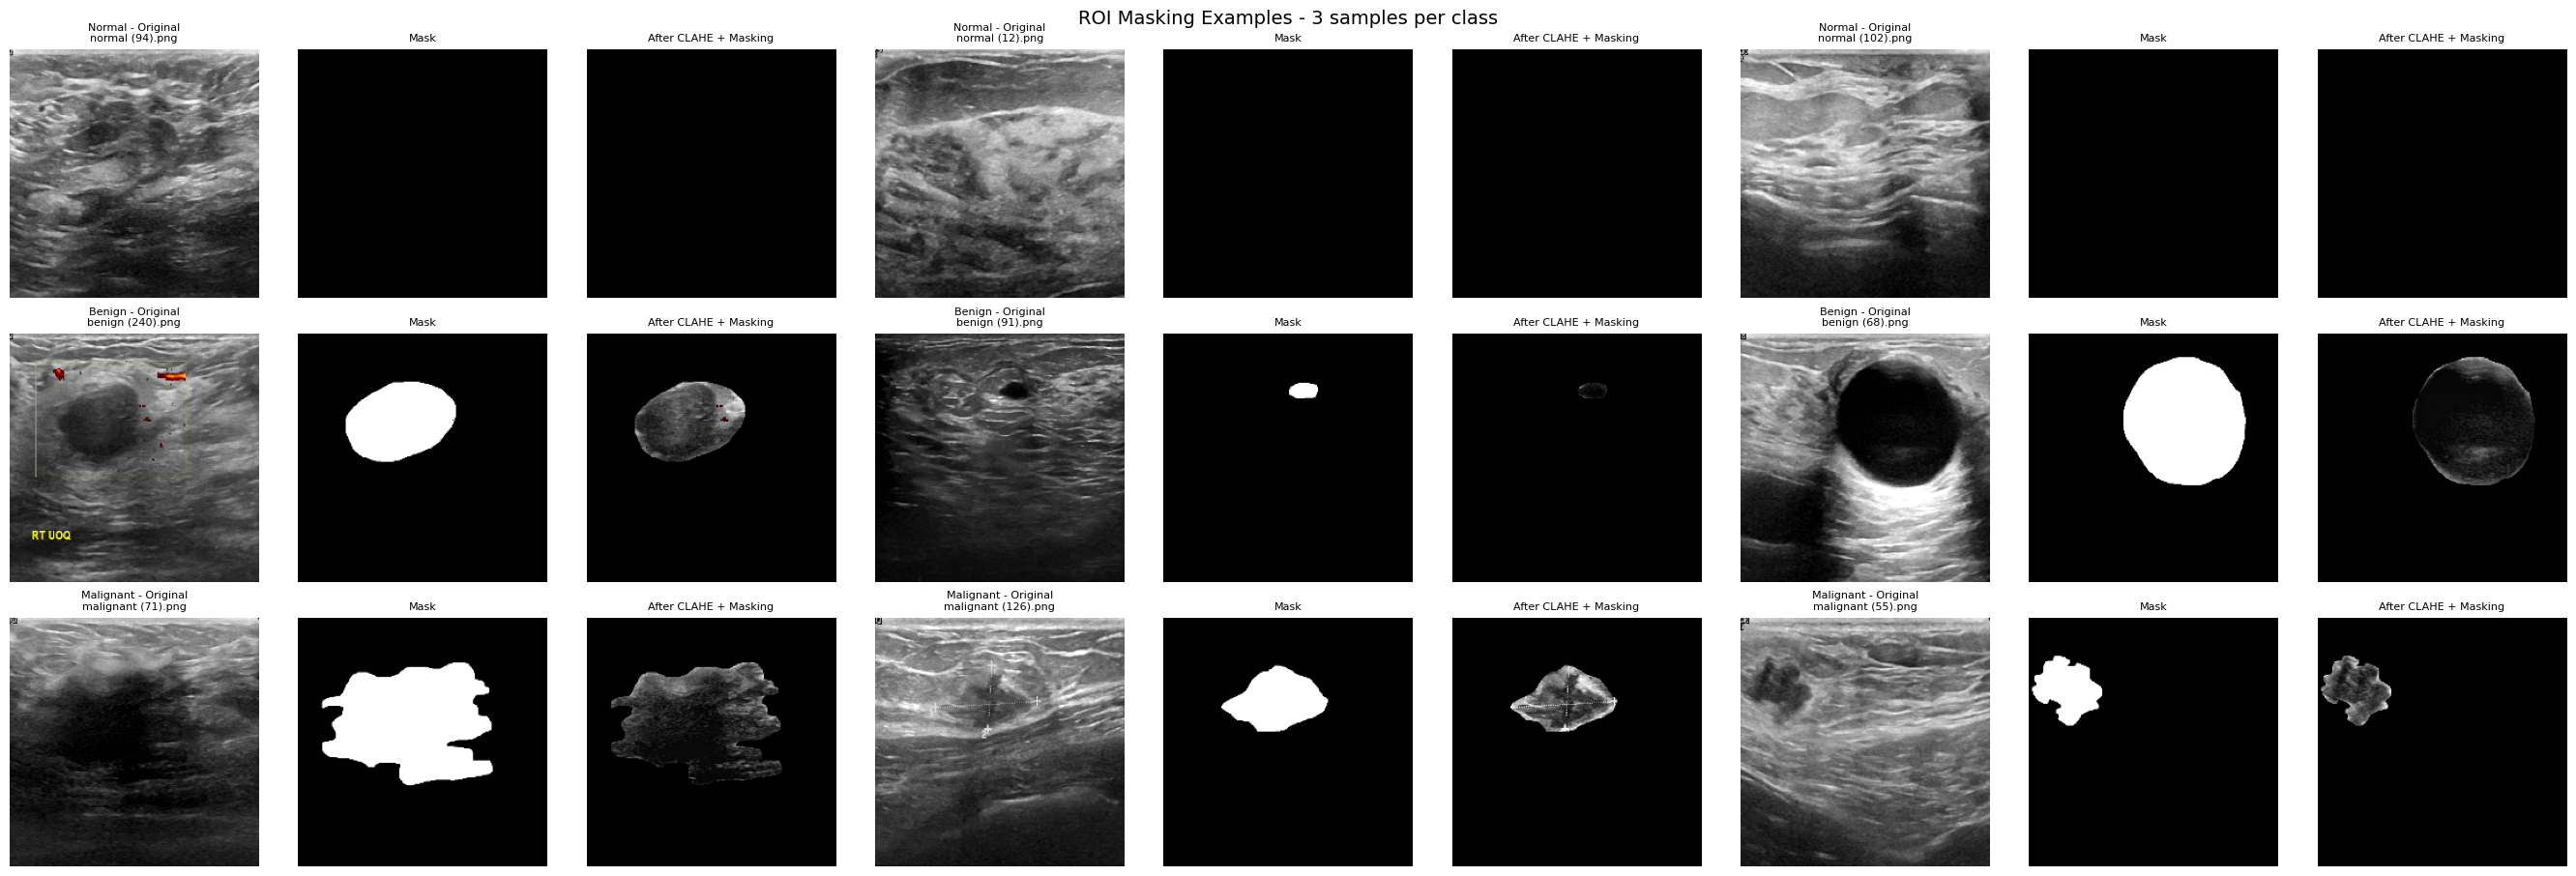

In [42]:
# ===================================================================
# VISUALIZATION FUNCTION FOR ROI MASKING EXAMPLES
# ===================================================================

def visualize_masking_examples(num_samples=3):
    """
    Visualize ROI masking examples: original image, mask, and masked result.
    Shows num_samples for each class (normal, benign, malignant).
    
    Args:
        num_samples: Number of samples to show per class
    """
    from pathlib import Path
    
    classes = ['normal', 'benign', 'malignant']
    split = 'train'  # Use training split for examples
    mask_split = 'training'  # train -> training mapping
    
    fig, axes = plt.subplots(len(classes), num_samples * 3, figsize=(num_samples * 9, len(classes) * 3))
    
    for class_idx, class_name in enumerate(classes):
        # Get image directory
        class_dir = os.path.join(DATA_DIR, split, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found: {class_dir}")
            continue
        
        # Get all images in this class
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        if len(image_files) == 0:
            print(f"Warning: No images found in {class_dir}")
            continue
        
        # Select random samples
        np.random.seed(42)
        selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
        
        for sample_idx, filename in enumerate(selected_files):
            # Load original image
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            
            # Apply CLAHE
            lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            limg = cv2.merge((cl, a, b))
            img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
            
            # Load mask
            base_name = Path(filename).stem
            mask_filename = f"{base_name}_mask.png"
            
            # Try standard path first
            mask_path = os.path.join(DATA_DIR, 'masking', mask_split, f'masking-{class_name}', mask_filename)
            
            # If malignant and not found, try typo version
            if not os.path.exists(mask_path) and class_name == 'malignant':
                mask_path_typo = os.path.join(DATA_DIR, 'masking', mask_split, 'masking-maglinant', mask_filename)
                if os.path.exists(mask_path_typo):
                    mask_path = mask_path_typo
            
            # Load and process mask
            mask = None
            img_masked = img_clahe.copy()
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
                    mask_normalized = mask_resized.astype(np.float32) / 255.0
                    mask_expanded = np.expand_dims(mask_normalized, axis=-1)
                    img_masked = (img_clahe.astype(np.float32) * mask_expanded).astype(np.uint8)
            
            # Plot: Original | Mask | Masked Result
            col_offset = sample_idx * 3
            
            # Original image
            ax_orig = axes[class_idx, col_offset] if len(classes) > 1 else axes[col_offset]
            ax_orig.imshow(img_resized)
            ax_orig.set_title(f'{class_name.capitalize()} - Original\n{filename}', fontsize=8)
            ax_orig.axis('off')
            
            # Mask
            ax_mask = axes[class_idx, col_offset + 1] if len(classes) > 1 else axes[col_offset + 1]
            if mask is not None:
                ax_mask.imshow(cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)), cmap='gray')
                ax_mask.set_title(f'Mask', fontsize=8)
            else:
                ax_mask.text(0.5, 0.5, 'Mask Not Found', ha='center', va='center', fontsize=10)
                ax_mask.set_title(f'Mask', fontsize=8)
            ax_mask.axis('off')
            
            # Masked Result
            ax_masked = axes[class_idx, col_offset + 2] if len(classes) > 1 else axes[col_offset + 2]
            ax_masked.imshow(img_masked)
            ax_masked.set_title(f'After CLAHE + Masking', fontsize=8)
            ax_masked.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'ROI Masking Examples - {num_samples} samples per class', fontsize=14, y=1.002)
    plt.show()

print('✅ Visualization function ready!')
print('Usage: visualize_masking_examples(num_samples=3)')
visualize_masking_examples(num_samples=3)

📊 DISTRIBUSI KELAS PADA DATASET

Training Set:
----------------------------------------
  Benign      :  430 (52.18%)
  Malignant   :  288 (34.95%)
  Normal      :  106 (12.86%)
  Total       :  824
  Imbalance Ratio: 4.06:1

Validation Set:
----------------------------------------
  Benign      :   63 (55.75%)
  Malignant   :   36 (31.86%)
  Normal      :   14 (12.39%)
  Total       :  113
  Imbalance Ratio: 4.50:1

Test Set:
----------------------------------------
  Benign      :   44 (47.31%)
  Malignant   :   36 (38.71%)
  Normal      :   13 (13.98%)
  Total       :   93
  Imbalance Ratio: 3.38:1

⚠️  PERHATIAN: Dataset memiliki ketidakseimbangan kelas!
   Kelas mayoritas (Benign) bisa mendominasi prediksi model.
   Solusi: Menggunakan Class Weights untuk menyeimbangkan.



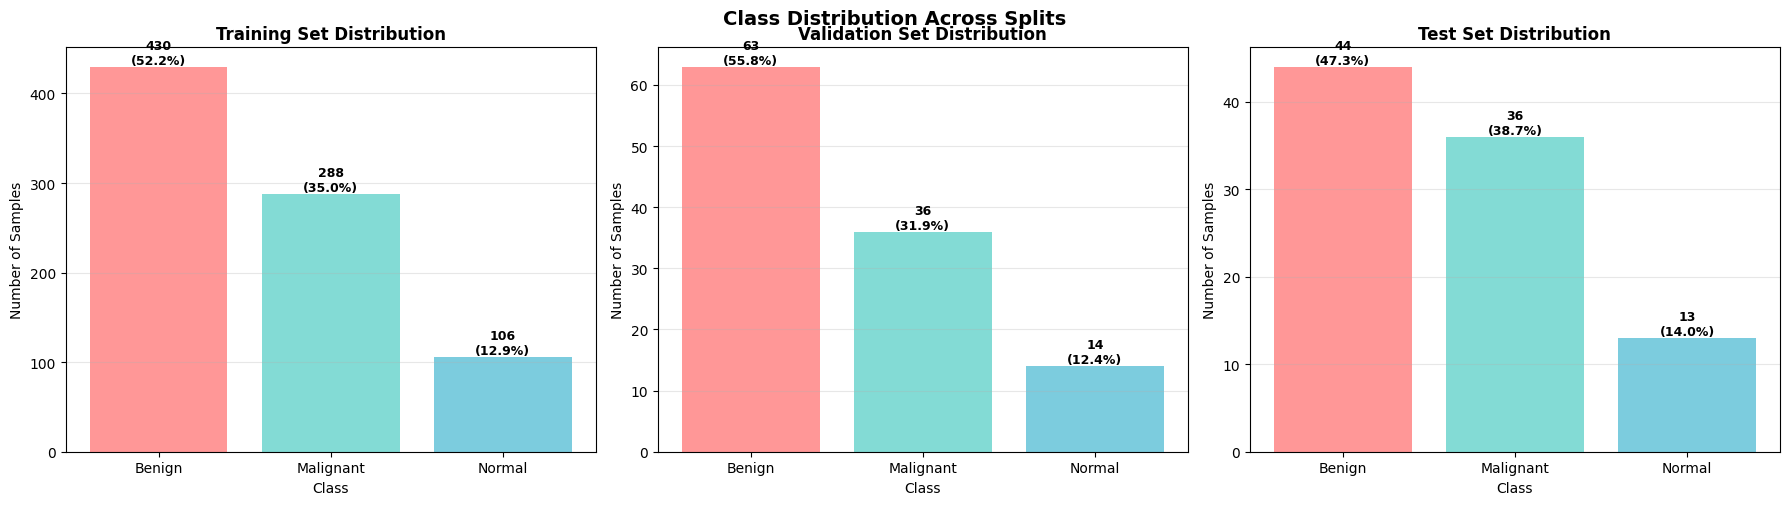

In [43]:
# ===================================================================
# ANALISIS DISTRIBUSI KELAS (Class Distribution Analysis)
# ===================================================================

print("=" * 60)
print("📊 DISTRIBUSI KELAS PADA DATASET")
print("=" * 60)

# Hitung distribusi untuk setiap split
splits = {
    'Training': train_generator,
    'Validation': validation_generator,
    'Test': test_generator
}

for split_name, generator in splits.items():
    print(f"\n{split_name} Set:")
    print("-" * 40)
    
    # Hitung jumlah sampel per kelas
    class_counts = {}
    for idx, class_name in enumerate(class_names):
        count = np.sum(generator.classes == idx)
        class_counts[class_name] = count
        percentage = (count / generator.samples) * 100
        print(f"  {class_name.capitalize():12s}: {count:4d} ({percentage:5.2f}%)")
    
    print(f"  {'Total':12s}: {generator.samples:4d}")
    
    # Hitung imbalance ratio
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count
    print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

print("\n" + "=" * 60)
print("⚠️  PERHATIAN: Dataset memiliki ketidakseimbangan kelas!")
print("   Kelas mayoritas (Benign) bisa mendominasi prediksi model.")
print("   Solusi: Menggunakan Class Weights untuk menyeimbangkan.")
print("=" * 60 + "\n")

# Visualisasi distribusi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, generator) in enumerate(splits.items()):
    class_counts = [np.sum(generator.classes == i) for i in range(NUM_CLASSES)]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    axes[idx].bar([c.capitalize() for c in class_names], class_counts, color=colors, alpha=0.7)
    axes[idx].set_title(f'{split_name} Set Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Number of Samples', fontsize=10)
    axes[idx].set_xlabel('Class', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Tambahkan nilai di atas bar
    for i, count in enumerate(class_counts):
        percentage = (count / generator.samples) * 100
        axes[idx].text(i, count, f'{count}\n({percentage:.1f}%)', 
                      ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold', y=1.002)
plt.show()

## 🔧 Perbaikan untuk Mengatasi Majority Class Bias

### Masalah yang Diatasi:
Model memprediksi **semua gambar sebagai satu kelas (Benign)** - fenomena **"Majority Class Bias"**

### Penyebab Utama:
1. **Ketidakseimbangan Data**: Dataset BUSI memiliki ketimpangan signifikan
   - Benign: ~437 gambar (60%)
   - Malignant: ~210 gambar (27%)
   - Normal: ~133 gambar (13%)

2. **Head Model Terlalu Sederhana**: Fitur fusion kompleks (1920+1280=3200 dimensi) langsung ke output layer

3. **Learning Rate Terlalu Kecil**: LR 0.0001 terlalu kecil untuk head baru yang harus belajar dari awal

### Solusi yang Diterapkan:

#### ✅ Solusi 1: Class Weights (Mengatasi Imbalance)
```python
class_weight=class_weights_dict
```
- Model "dihukum" lebih berat jika salah menebak kelas minoritas
- Memaksa model memperhatikan Malignant & Normal, bukan hanya Benign

#### ✅ Solusi 2: Improved Head Architecture
```python
x = layers.Dense(256, activation='relu')(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
```
- Tambahan layer Dense(256) untuk memproses fitur fusion lebih baik
- BatchNormalization untuk stabilkan pembelajaran
- Dropout(0.5) lebih tinggi untuk mencegah overfitting

#### ✅ Solusi 3: Learning Rate Lebih Tinggi
```python
learning_rate=0.001  # Naikkan dari 0.0001
```
- LR lebih tinggi agar head baru belajar lebih cepat
- ReduceLROnPlateau akan menurunkan otomatis jika diperlukan

### Hasil yang Diharapkan:
- Model tidak lagi hanya memprediksi Benign
- Precision & Recall untuk Malignant dan Normal meningkat signifikan
- F1-Score lebih seimbang antar kelas

## ⚠️ Solusi Tambahan Jika Model Masih Prediksi Semua Benign

### Jika setelah training model masih memprediksi semua sebagai Benign, coba langkah ini:

#### 🔧 **Opsi 1: Focal Loss (Recommended)**
Ganti `categorical_crossentropy` dengan Focal Loss yang lebih agresif mengatasi imbalance:

```python
# Tambahkan di cell setelah build model
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# Saat compile model, ganti loss:
model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=0.25),  # Ganti ini
    metrics=['accuracy']
)
```

#### 🔧 **Opsi 2: Class Weights Lebih Ekstrem**
Kalikan class weights dengan faktor 2-3x:

```python
# Setelah hitung class_weights
class_weights_extreme = {k: v * 2.5 for k, v in class_weights_dict.items()}
class_weights_extreme[0] = class_weights_dict[0]  # Benign tetap normal

# Gunakan saat fit:
history = model.fit(..., class_weight=class_weights_extreme)
```

#### 🔧 **Opsi 3: Unfreeze Beberapa Layer Backbone**
Jika head sudah belajar tapi masih bias, unfreeze layer terakhir backbone:

```python
# Setelah beberapa epoch (misal epoch 10), jalankan:
base_model.trainable = True
# Bekukan semua kecuali 20 layer terakhir
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile ulang dengan LR lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # LR lebih kecil untuk fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Lanjutkan training
history2 = model.fit(..., initial_epoch=10, epochs=30)
```

#### 🔧 **Opsi 4: Data Augmentation Lebih Agresif untuk Kelas Minoritas**
Oversample kelas Malignant & Normal:

```python
# Modifikasi train_datagen untuk kelas minoritas
from imblearn.over_sampling import SMOTE  # pip install imbalanced-learn

# Atau manual: copy gambar Malignant & Normal 2-3x di folder train
```

### 🎯 Cara Cek:
Jalankan cell "Quick Check" setelah training untuk lihat distribusi prediksi!

## 🔍 Troubleshooting Flow: Model Prediksi Semua Benign

```
START: Model prediksi semua/hampir semua Benign
    ↓
┌───────────────────────────────────────────────────────────┐
│ STEP 1: Cek Distribusi Prediksi (Quick Check Cell)       │
│ - Jalankan cell "Quick Check"                            │
│ - Lihat berapa % prediksi Benign                         │
└───────────────────────────────────────────────────────────┘
    ↓
    Apakah >90% prediksi adalah Benign?
    │
    ├─ YES ──→ STEP 2: Gunakan Focal Loss
    │          ┌──────────────────────────────────────────┐
    │          │ Di cell training:                        │
    │          │ use_focal_loss = True                    │
    │          │ Train ulang dari awal                    │
    │          └──────────────────────────────────────────┘
    │               ↓
    │          Masih >80% Benign?
    │               ↓
    │          STEP 3: Extreme Class Weights
    │          ┌──────────────────────────────────────────┐
    │          │ Uncomment class_weights_extreme          │
    │          │ Train ulang                              │
    │          └──────────────────────────────────────────┘
    │               ↓
    │          Masih >70% Benign?
    │               ↓
    │          STEP 4: Fine-Tuning Backbone
    │          ┌──────────────────────────────────────────┐
    │          │ Uncomment cell Fine-Tuning               │
    │          │ Unfreeze 30 layers terakhir              │
    │          │ Train dengan LR=1e-5                     │
    │          └──────────────────────────────────────────┘
    │
    └─ NO (60-90%) ──→ ACCEPTABLE
                       ┌──────────────────────────────────┐
                       │ Model cukup baik, tapi bisa      │
                       │ ditingkatkan dengan:             │
                       │ - Tambah epochs                  │
                       │ - Fine-tuning (opsional)         │
                       └──────────────────────────────────┘

TARGET: Distribusi prediksi seimbang
        Normal: ~20-40%, Benign: ~30-50%, Malignant: ~20-40%
```

### 📊 Metrik Keberhasilan:
- ✅ **IDEAL**: Prediksi terdistribusi ke semua kelas (masing-masing 20-40%)
- ⚠️ **MODERATE**: Benign 50-70%, sisanya terbagi
- ❌ **PROBLEM**: Benign >80% atau prediksi hanya 1-2 kelas

### 🎯 Tips Tambahan:
1. **Cek Class Weights Output**: Weight untuk Normal dan Malignant harus >1.5x Benign
2. **Monitor Training Loss**: Jika loss turun tapi accuracy tidak naik → model overfitting ke kelas mayoritas
3. **Validation Accuracy**: Jika val_acc lebih tinggi dari train_acc → model tidak belajar dengan baik

In [44]:
def build_hybrid_model():
    # 1. Input Layer
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    # 2. Backbone: DenseNet201 (Transfer Learning)
    base_model = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    
    # Bekukan backbone agar bobot ImageNet tidak rusak saat awal training
    base_model.trainable = False 
    
    # Output dari backbone (Fitur Vector 1920 dimensi)
    features = base_model.output
    
    # 3. Fast Learning Network (FLN) Head - IMPROVED VERSION
    # Jalur A: Hidden Layer (Non-Linear)
    hidden_path = layers.Dense(NEURONS_FLN, activation='relu', name='fln_hidden')(features)
    hidden_path = layers.Dropout(DROPOUT_RATE, name='fln_dropout')(hidden_path)
    
    # Jalur B: Direct Path (Linear/Bypass)
    # Fitur asli langsung diteruskan tanpa diubah
    
    # Penggabungan (Concatenate) Jalur A dan Jalur B
    concatenated = layers.concatenate([hidden_path, features], name='fln_concat')
    
    # 4. IMPROVED HEAD - Tambahan Layer untuk mencegah Majority Class Bias
    # Layer Dense tambahan untuk memproses fitur gabungan lebih baik
    x = layers.Dense(256, activation='relu', name='fusion_dense')(concatenated)
    x = layers.BatchNormalization(name='fusion_bn')(x)  # Stabilkan pembelajaran
    x = layers.Dropout(0.5, name='fusion_dropout')(x)   # Dropout lebih tinggi
    
    # 5. Output Layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(x)
    
    # Build Model
    model = Model(inputs=inputs, outputs=outputs, name="DenseNet201_FLN_Hybrid_ROI")
    return model

model = build_hybrid_model()
model.summary()

Model: "DenseNet201_FLN_Hybrid_ROI"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,840,922 (75.69 MB)

 Trainable params: 1,518,426 (5.79 MB)

 Non-trainable params: 18,322,496 (69.89 MB)

In [ ]:
# ===================================================================
# FOCAL LOSS - Alternatif Loss Function untuk Imbalanced Data
# ===================================================================
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss untuk mengatasi class imbalance yang ekstrem.
    
    Args:
        gamma: Focusing parameter (default 2.0)
               Semakin tinggi, semakin fokus ke hard examples
        alpha: Balancing parameter (default 0.25)
               Weight untuk kelas positif
    
    Returns:
        Loss function untuk Keras
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        # Cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Focal loss weight: alpha * (1 - p)^gamma
        # Memberikan bobot lebih besar pada contoh yang sulit (low probability)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        
        # Calculate focal loss
        loss = weight * cross_entropy
        
        return K.sum(loss, axis=-1)
    
    return focal_loss_fixed


print("=" * 60)
print("📌 FOCAL LOSS FUNCTION READY")
print("=" * 60)
print("Focal Loss lebih agresif mengatasi class imbalance dibanding")
print("categorical_crossentropy dengan class_weight.")
print("\nUntuk menggunakan Focal Loss:")
print("1. Uncomment baris 'loss=focal_loss(...)' di cell training")
print("2. Comment baris 'loss='categorical_crossentropy''")
print("=" * 60 + "\n")

In [ ]:
# ===================================================================
# PENANGANAN CLASS IMBALANCE - CLASS WEIGHTS
# ===================================================================
from sklearn.utils import class_weight

# Hitung bobot kelas secara otomatis untuk mengatasi ketidakseimbangan data
# Dataset BUSI: Benign (437) >> Malignant (210) >> Normal (133)
# Class weights akan membuat model "dihukum" lebih berat jika salah menebak kelas minoritas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Ubah ke format dictionary yang diminta Keras
class_weights_dict = dict(enumerate(class_weights))

print("=" * 60)
print("📊 CLASS WEIGHTS (Mengatasi Ketidakseimbangan Data)")
print("=" * 60)
for idx, class_name in enumerate(class_names):
    weight = class_weights_dict[idx]
    print(f"  {class_name.capitalize():12s} (Class {idx}): {weight:.4f}")
print("=" * 60)
print("💡 Interpretasi: Semakin tinggi weight, semakin berat hukuman jika salah prediksi")
print("   Ini memaksa model untuk memperhatikan kelas minoritas (Malignant/Normal)")
print("=" * 60 + "\n")

# ===================================================================
# OPSI: CLASS WEIGHTS EKSTREM (Jika model masih bias ke Benign)
# ===================================================================
# Uncomment baris di bawah jika model masih prediksi semua Benign setelah training
# class_weights_extreme = {k: v * 2.5 for k, v in class_weights_dict.items()}
# class_weights_extreme[0] = class_weights_dict[0]  # Benign tetap normal, minoritas diperbesar
# print("⚠️  USING EXTREME CLASS WEIGHTS (2.5x for minority classes)")
# class_weights_dict = class_weights_extreme  # Ganti dengan extreme weights

# ===================================================================
# CALLBACKS & OPTIMIZER CONFIGURATION
# ===================================================================

# 1. Definisi Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model_densenet_roi_masking.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 2. Compile Model dengan Adam Optimizer
# PERBAIKAN: Naikkan Learning Rate awal dari 0.0001 ke 0.001
# Karena backbone dibekukan, Head baru perlu LR lebih tinggi untuk belajar cepat
LEARNING_RATE_INITIAL = 0.001  # Naikkan dari 0.0001

print(f"🚀 Konfigurasi Optimizer: Adam")
print(f"   Learning Rate Initial: {LEARNING_RATE_INITIAL} (dinaikkan untuk Head baru)")
print(f"   Beta_1: 0.9, Beta_2: 0.999")
print(f"   ReduceLROnPlateau akan menurunkan LR otomatis jika plateau\n")

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE_INITIAL,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

# ===================================================================
# PILIHAN LOSS FUNCTION
# ===================================================================
# OPSI 1: Categorical Crossentropy + Class Weights (DEFAULT)
use_focal_loss = False  # Set True untuk menggunakan Focal Loss

if use_focal_loss:
    print("🎯 Using FOCAL LOSS (lebih agresif mengatasi imbalance)")
    loss_function = focal_loss(gamma=2.0, alpha=0.25)
    # Focal Loss sudah handle imbalance, class_weight tidak perlu digunakan
    class_weights_to_use = None
else:
    print("🎯 Using CATEGORICAL CROSSENTROPY + CLASS WEIGHTS")
    loss_function = 'categorical_crossentropy'
    class_weights_to_use = class_weights_dict

model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy']
)

# 3. Training dengan Class Weights
print(f"\n{'='*60}")
print(f"🎯 Mulai Training DenseNet201 + ROI Masking")
print(f"{'='*60}")
print(f"Dataset: {DATA_DIR}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Classes: {NUM_CLASSES} ({', '.join(class_names)})")
print(f"Preprocessing: CLAHE + ROI Masking")
print(f"Loss Function: {'Focal Loss' if use_focal_loss else 'Categorical Crossentropy'}")
print(f"Class Weights: {'✗ DISABLED (Focal Loss handles it)' if use_focal_loss else '✓ ENABLED (Balanced)'}")
print(f"Improved Head: ✓ Dense(256) + BatchNorm + Dropout(0.5)")
print(f"{'='*60}\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    class_weight=class_weights_to_use  # 🔥 None jika pakai Focal Loss
)

print("\n✅ Training selesai!")
print("\n" + "="*60)
print("📝 LANGKAH SELANJUTNYA:")
print("="*60)
print("1. Jalankan cell 'Quick Check' untuk cek distribusi prediksi")
print("2. Jika masih prediksi semua Benign:")
print("   a) Set use_focal_loss = True dan train ulang, ATAU")
print("   b) Uncomment class_weights_extreme dan train ulang, ATAU")
print("   c) Unfreeze beberapa layer backbone untuk fine-tuning")
print("="*60)

📊 CLASS WEIGHTS (Mengatasi Ketidakseimbangan Data)
  Benign       (Class 0): 0.6388
  Malignant    (Class 1): 0.9537
  Normal       (Class 2): 2.5912
💡 Interpretasi: Semakin tinggi weight, semakin berat hukuman jika salah prediksi
   Ini memaksa model untuk memperhatikan kelas minoritas (Malignant/Normal)

🚀 Konfigurasi Optimizer: Adam
   Learning Rate Initial: 0.001 (dinaikkan untuk Head baru)
   Beta_1: 0.9, Beta_2: 0.999
   ReduceLROnPlateau akan menurunkan LR otomatis jika plateau

🎯 Mulai Training DenseNet201 + ROI Masking
Dataset: D:\Kuliah\Semester 5\HUMIC\dataset gabungan
Epochs: 30
Batch Size: 16
Classes: 3 (benign, malignant, normal)
Preprocessing: CLAHE + ROI Masking
Class Weights: ✓ ENABLED (Mengatasi imbalance)
Improved Head: ✓ Dense(256) + BatchNorm + Dropout(0.5)

Epoch 1/30
Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.3821 - loss: 1.6328
Epoch 1: val_accuracy improved from None to 0.25893, saving model to best_model_densenet_roi_masking.keras

Epoch

d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.25893 to 0.26786, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.3125 - loss: 1.3625 - val_accuracy: 0.2679 - val_loss: 1.8540 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.3125 - loss: 1.3625 - val_accuracy: 0.2679 - val_loss: 1.8540 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.3733 - loss: 1.3975
Epoch 3: val_accuracy improved from 0.26786 to 0.61607, saving model to best_model_densenet_roi_masking.keras

Epoch 3: val_accuracy improved from 0.26786 to 0.61607, saving model to best_model_densenet_roi_masking.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 805ms/step - accuracy: 0.3787 - loss: 1.3975 - val_accuracy: 0.6161 - val_loss: 1.0591 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 805ms/step - accuracy: 0.3787 - loss: 1.3975 - val_accuracy: 0.6161 - val_loss: 1.0591 - learning_rate: 0

In [ ]:
# ===================================================================
# FINE-TUNING BACKBONE (JALANKAN HANYA JIKA MODEL MASIH BIAS!)
# ===================================================================
# ⚠️ PERINGATAN: Hanya jalankan cell ini jika:
#    1. Training sudah selesai
#    2. Model masih prediksi >80% ke Benign
#    3. Anda sudah coba Focal Loss atau Extreme Weights tapi belum berhasil

"""
# UNCOMMENT UNTUK MENJALANKAN FINE-TUNING

print("="*60)
print("🔄 MEMULAI FINE-TUNING BACKBONE")
print("="*60)

# Load model terbaik dari training sebelumnya
model = tf.keras.models.load_model('best_model_densenet_roi_masking.keras')

# Ambil backbone (DenseNet201)
base_model = model.layers[1]  # Layer kedua adalah DenseNet201

# Unfreeze layer backbone
base_model.trainable = True

# Bekukan semua layer kecuali 30 layer terakhir
# DenseNet201 punya ~700 layers, kita hanya unfreeze ~4% terakhir
print(f"Total layers di backbone: {len(base_model.layers)}")
print(f"Unfreezing last 30 layers untuk fine-tuning...")

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Hitung berapa layer yang trainable
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers: {trainable_count}/{len(base_model.layers)}")

# Compile ulang dengan Learning Rate SANGAT KECIL
# Karena kita fine-tune, tidak boleh mengubah weights terlalu drastis
optimizer_finetune = tf.keras.optimizers.Adam(
    learning_rate=1e-5,  # 100x lebih kecil dari initial LR
    beta_1=0.9,
    beta_2=0.999
)

# Gunakan loss yang sama dengan sebelumnya
if use_focal_loss:
    loss_function = focal_loss(gamma=2.0, alpha=0.25)
    class_weights_to_use = None
else:
    loss_function = 'categorical_crossentropy'
    class_weights_to_use = class_weights_dict

model.compile(
    optimizer=optimizer_finetune,
    loss=loss_function,
    metrics=['accuracy']
)

print("\n" + "="*60)
print("🎯 Mulai Fine-Tuning")
print("="*60)
print(f"Learning Rate: 1e-5 (sangat kecil)")
print(f"Epochs: 10 (lebih sedikit untuk mencegah overfitting)")
print(f"Trainable backbone layers: {trainable_count}")
print("="*60 + "\n")

# Callback untuk fine-tuning
checkpoint_finetune = ModelCheckpoint(
    'best_model_densenet_roi_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_finetune = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Lebih pendek karena fine-tuning
    restore_best_weights=True,
    verbose=1
)

lr_scheduler_finetune = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Fine-tuning training
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10,  # Lebih sedikit epochs
    callbacks=[checkpoint_finetune, early_stopping_finetune, lr_scheduler_finetune],
    class_weight=class_weights_to_use
)

print("\n✅ Fine-tuning selesai!")
print("Model yang sudah di-finetune disimpan sebagai: best_model_densenet_roi_finetuned.keras")
print("\nSekarang jalankan cell evaluasi untuk melihat improvement!")
"""

print("="*60)
print("📌 FINE-TUNING CELL (COMMENTED)")
print("="*60)
print("Cell ini berisi kode untuk fine-tuning backbone.")
print("Uncomment kode di atas untuk menjalankannya.")
print("\n⚠️  PERINGATAN: Hanya jalankan jika model masih bias setelah training!")
print("="*60)

## 🔄 Fine-Tuning (Opsional - Jalankan Jika Model Masih Bias)

**Kapan menggunakan Fine-Tuning?**
- Setelah training selesai, model masih prediksi >80% ke Benign
- Validation accuracy sudah plateau tapi test accuracy rendah
- Ingin meningkatkan performa model lebih lanjut

**Cara kerja:**
1. Unfreeze beberapa layer terakhir dari backbone DenseNet201
2. Train ulang dengan learning rate sangat kecil (1e-5)
3. Backbone ikut "disesuaikan" dengan dataset BUSI kita

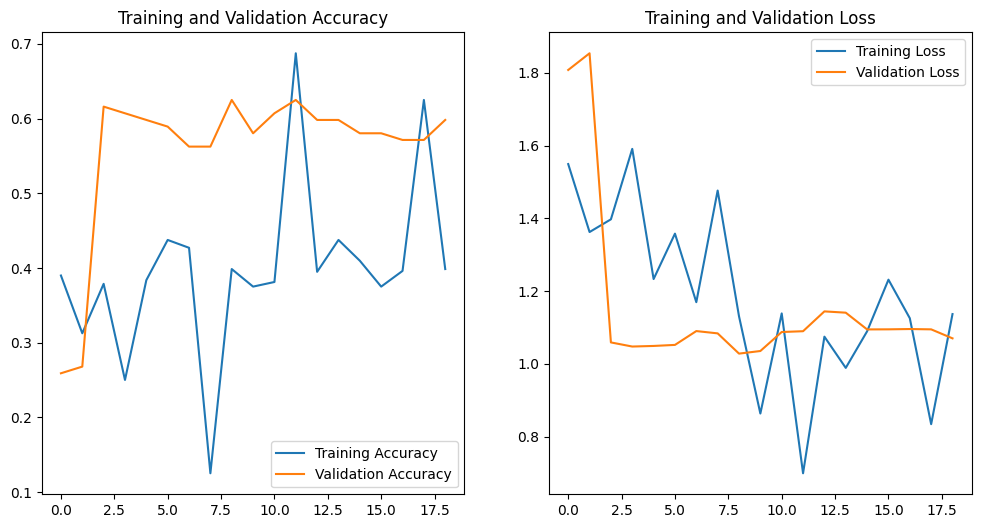

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
# ===================================================================
# EVALUASI MODEL PADA DATA TEST
# ===================================================================

print("🔍 Evaluasi Model pada Data Test...")

# Load model terbaik
best_model = tf.keras.models.load_model('best_model_densenet_roi_masking.keras')

# Reset generator untuk memastikan dimulai dari awal
test_generator.reset()

# Prediksi pada data test
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = best_model.predict(test_generator, steps=test_steps, verbose=1)

# Dapatkan kelas prediksi dan kelas sebenarnya
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Pastikan jumlah prediksi sesuai dengan jumlah data test
predicted_classes = predicted_classes[:len(true_classes)]

print(f"\n✅ Evaluasi selesai!")
print(f"Total sampel test: {test_generator.samples}")
print(f"Total prediksi: {len(predicted_classes)}")
print(f"Total true labels: {len(true_classes)}")

🔍 Evaluasi Model pada Data Test...
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93


In [48]:
# ===================================================================
# QUICK CHECK: Apakah Model Masih Prediksi Semua Benign?
# ===================================================================

print("=" * 60)
print("🔍 QUICK CHECK - Distribusi Prediksi pada Validation Set")
print("=" * 60)

# Reset generator
validation_generator.reset()

# Prediksi pada validation set (cepat)
val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
val_predictions = model.predict(validation_generator, steps=val_steps, verbose=0)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Hitung distribusi prediksi
print("\nDistribusi Prediksi Model:")
print("-" * 40)
for idx, class_name in enumerate(class_names):
    count = np.sum(val_predicted_classes == idx)
    percentage = (count / len(val_predicted_classes)) * 100
    print(f"  {class_name.capitalize():12s}: {count:4d} ({percentage:5.2f}%)")

print("\n" + "=" * 60)
# Cek jika semua prediksi sama
unique_predictions = len(np.unique(val_predicted_classes))
if unique_predictions == 1:
    print("⚠️  WARNING: Model masih memprediksi SEMUA sampel sebagai 1 kelas!")
    print("   Kemungkinan penyebab:")
    print("   - Training belum cukup lama (epoch masih sedikit)")
    print("   - Learning rate terlalu kecil")
    print("   - Model butuh fine-tuning backbone (unfreeze layers)")
elif unique_predictions == NUM_CLASSES:
    print("✅ BAGUS: Model memprediksi semua kelas (tidak bias ke 1 kelas)")
else:
    print(f"⚠️  Model hanya memprediksi {unique_predictions}/{NUM_CLASSES} kelas")
print("=" * 60 + "\n")

🔍 QUICK CHECK - Distribusi Prediksi pada Validation Set

Distribusi Prediksi Model:
----------------------------------------
  Benign      :  104 (92.04%)
  Malignant   :    9 ( 7.96%)
  Normal      :    0 ( 0.00%)

⚠️  Model hanya memprediksi 2/3 kelas


Distribusi Prediksi Model:
----------------------------------------
  Benign      :  104 (92.04%)
  Malignant   :    9 ( 7.96%)
  Normal      :    0 ( 0.00%)

⚠️  Model hanya memprediksi 2/3 kelas



In [49]:
# ===================================================================
# PERHITUNGAN METRIK EVALUASI
# ===================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Hitung metrik untuk setiap kelas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

# Hitung metrik rata-rata
precision_avg = precision_score(true_classes, predicted_classes, average='weighted')
recall_avg = recall_score(true_classes, predicted_classes, average='weighted')
f1_avg = f1_score(true_classes, predicted_classes, average='weighted')

# Tampilkan hasil
print("=" * 70)
print("HASIL EVALUASI MODEL PADA DATA TEST (CLAHE + ROI Masking)")
print("=" * 70)
print(f"\n📊 Overall Metrics:")
print(f"  Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision : {precision_avg:.4f}")
print(f"  Recall    : {recall_avg:.4f}")
print(f"  F1-Score  : {f1_avg:.4f}")

print(f"\n📊 Per-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n  {class_name.upper()}:")
    print(f"    Precision : {precision[i]:.4f}")
    print(f"    Recall    : {recall[i]:.4f}")
    print(f"    F1-Score  : {f1[i]:.4f}")

print("\n" + "=" * 70)

HASIL EVALUASI MODEL PADA DATA TEST (CLAHE + ROI Masking)

📊 Overall Metrics:
  Accuracy  : 0.4946 (49.46%)
  Precision : 0.4634
  Recall    : 0.4946
  F1-Score  : 0.3649

📊 Per-Class Metrics:

  BENIGN:
    Precision : 0.4886
    Recall    : 0.9773
    F1-Score  : 0.6515

  MALIGNANT:
    Precision : 0.6000
    Recall    : 0.0833
    F1-Score  : 0.1463

  NORMAL:
    Precision : 0.0000
    Recall    : 0.0000
    F1-Score  : 0.0000



d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [50]:
# ===================================================================
# CLASSIFICATION REPORT
# ===================================================================

print("📋 Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_names, digits=4)
print(report)

# Simpan report sebagai dictionary untuk visualisasi nanti
from sklearn.metrics import classification_report
report_dict = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)

📋 Classification Report:

              precision    recall  f1-score   support

      benign     0.4886    0.9773    0.6515        44
   malignant     0.6000    0.0833    0.1463        36
      normal     0.0000    0.0000    0.0000        13

    accuracy                         0.4946        93
   macro avg     0.3629    0.3535    0.2660        93
weighted avg     0.4634    0.4946    0.3649        93



d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

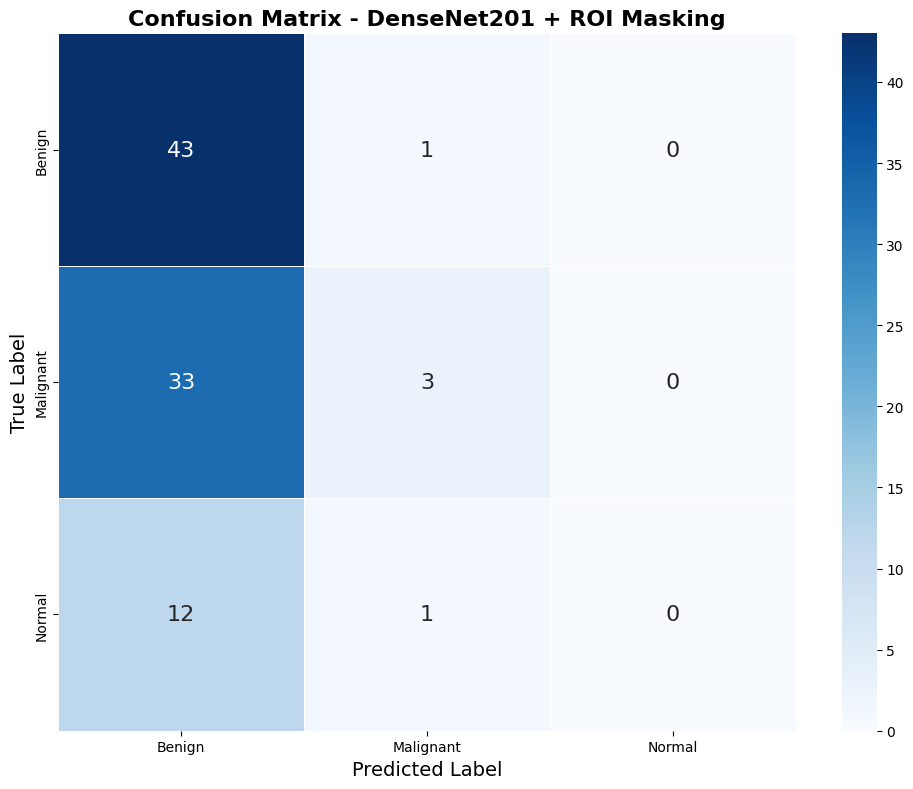

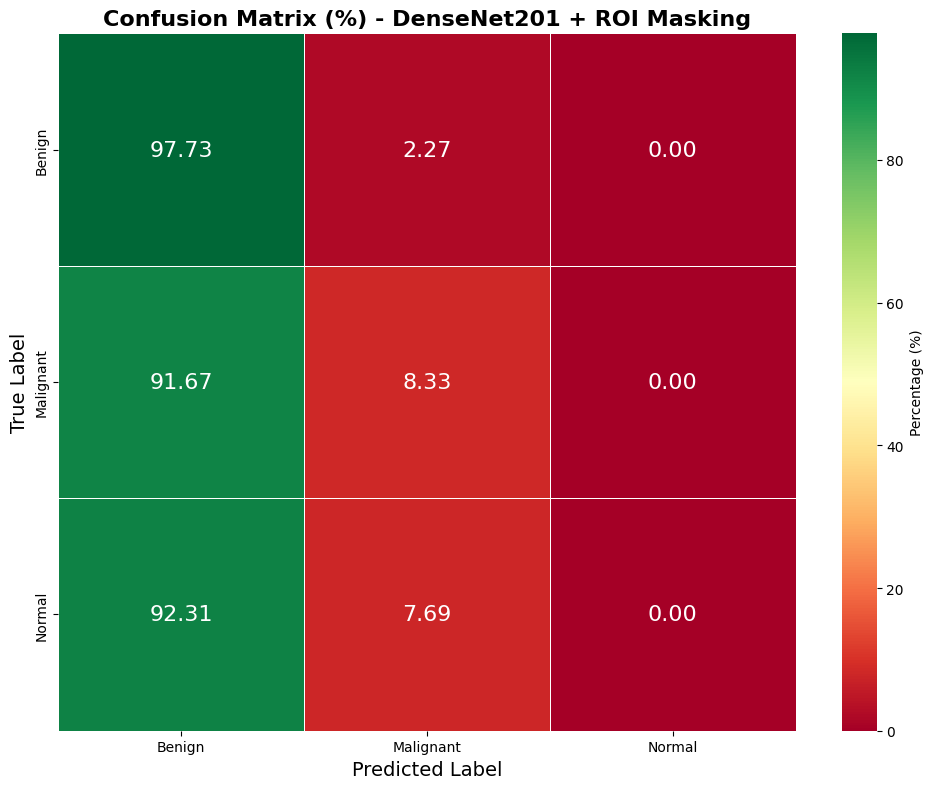

In [51]:
# ===================================================================
# CONFUSION MATRIX VISUALIZATION
# ===================================================================

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16})

plt.title('Confusion Matrix - DenseNet201 + ROI Masking', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Tampilkan confusion matrix dalam bentuk persentase
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16}, cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix (%) - DenseNet201 + ROI Masking', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

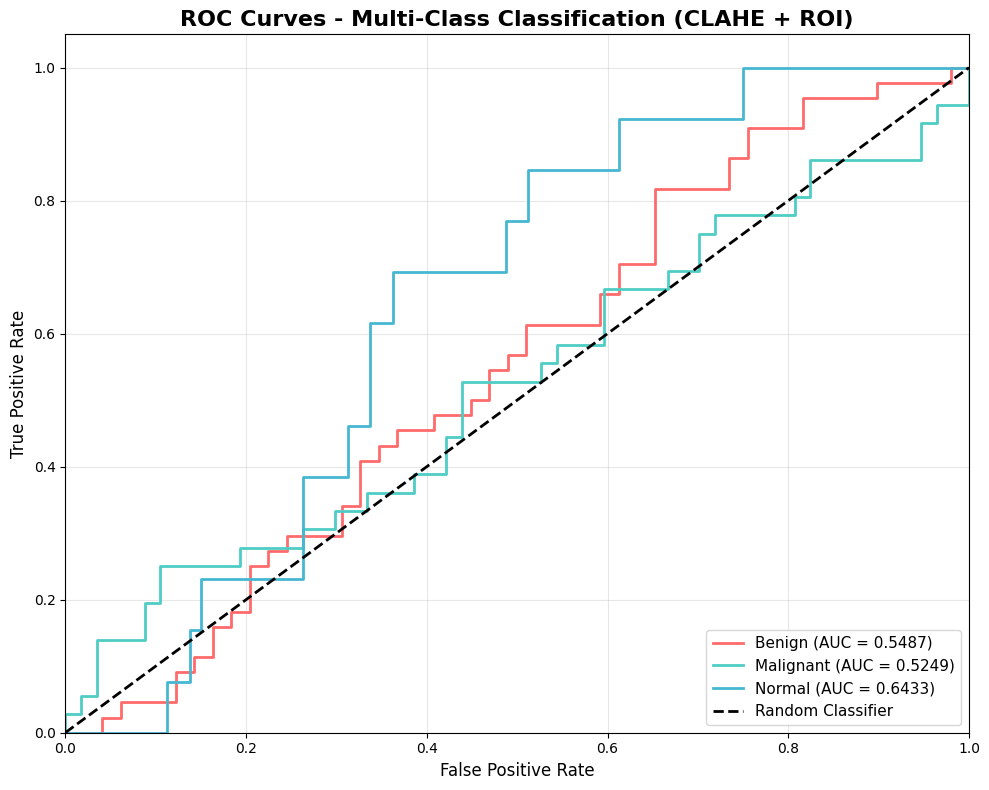

📊 AUC Scores:
  Benign: 0.5487
  Malignant: 0.5249
  Normal: 0.6433


In [52]:
# ===================================================================
# ROC CURVE & AUC SCORE (Multi-Class)
# ===================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels untuk ROC multi-class
y_test_binarized = label_binarize(true_classes, classes=range(NUM_CLASSES))
y_score = predictions[:test_generator.samples]

# Compute ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i].capitalize()} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification (CLAHE + ROI)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name.capitalize()}: {roc_auc[i]:.4f}")

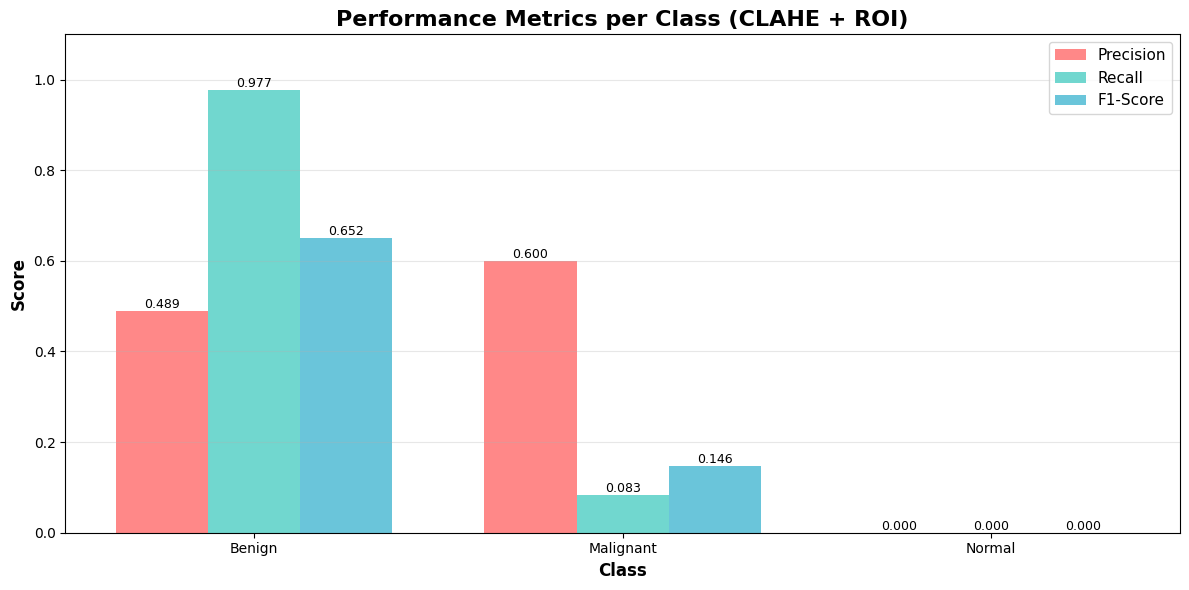

In [53]:
# ===================================================================
# METRIK PER-CLASS VISUALIZATION (Bar Charts)
# ===================================================================

# Prepare data
metrics_data = {
    'Class': [c.capitalize() for c in class_names],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_data)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#4ECDC4', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#45B7D1', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics per Class (CLAHE + ROI)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in class_names])
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [54]:
# ===================================================================
# SUMMARY TABLE - COMPREHENSIVE RESULTS
# ===================================================================

import pandas as pd

# Create comprehensive summary table
summary_data = []
for i, class_name in enumerate(class_names):
    summary_data.append({
        'Class': class_name.capitalize(),
        'Precision': f"{precision[i]:.4f}",
        'Recall': f"{recall[i]:.4f}",
        'F1-Score': f"{f1[i]:.4f}",
        'Support': int(cm[i].sum())
    })

# Add overall metrics
summary_data.append({
    'Class': 'OVERALL (Weighted)',
    'Precision': f"{precision_avg:.4f}",
    'Recall': f"{recall_avg:.4f}",
    'F1-Score': f"{f1_avg:.4f}",
    'Support': int(cm.sum())
})

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("📊 COMPREHENSIVE EVALUATION SUMMARY (CLAHE + ROI Masking)")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Display as styled table
from IPython.display import display
styled_df = df_summary.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt',
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4ECDC4'), ('color', 'white'), 
                                  ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:last-child', 'props': [('background-color', '#FFE66D'), ('font-weight', 'bold')]}
])

display(styled_df)


📊 COMPREHENSIVE EVALUATION SUMMARY (CLAHE + ROI Masking)
             Class Precision Recall F1-Score  Support
            Benign    0.4886 0.9773   0.6515       44
         Malignant    0.6000 0.0833   0.1463       36
            Normal    0.0000 0.0000   0.0000       13
OVERALL (Weighted)    0.4634 0.4946   0.3649       93


,Class,Precision,Recall,F1-Score,Support
0,Benign,0.4886,0.9773,0.6515,44
1,Malignant,0.6000,0.0833,0.1463,36
2,Normal,0.0000,0.0000,0.0000,13
3,OVERALL (Weighted),0.4634,0.4946,0.3649,93


In [55]:
# ===================================================================
# TRAINING HISTORY ANALYSIS
# ===================================================================

# Create detailed training history table
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': [f"{acc:.4f}" for acc in history.history['accuracy']],
    'Val Accuracy': [f"{acc:.4f}" for acc in history.history['val_accuracy']],
    'Train Loss': [f"{loss:.4f}" for loss in history.history['loss']],
    'Val Loss': [f"{loss:.4f}" for loss in history.history['val_loss']]
})

print("\n📈 TRAINING HISTORY (First and Last 5 Epochs):")
print("="*80)
print("First 5 Epochs:")
print(history_df.head().to_string(index=False))
print("\nLast 5 Epochs:")
print(history_df.tail().to_string(index=False))
print("="*80)

# Find best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"\n🏆 Best Epoch: {best_epoch}")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")


📈 TRAINING HISTORY (First and Last 5 Epochs):
First 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
     1         0.3899       0.2589     1.5494   1.8081
     2         0.3125       0.2679     1.3625   1.8540
     3         0.3787       0.6161     1.3975   1.0591
     4         0.2500       0.6071     1.5912   1.0477
     5         0.3837       0.5982     1.2333   1.0494

Last 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
    15         0.4097       0.5804     1.0896   1.0948
    16         0.3750       0.5804     1.2316   1.0950
    17         0.3960       0.5714     1.1256   1.0959
    18         0.6250       0.5714     0.8343   1.0950
    19         0.3985       0.5982     1.1370   1.0702

🏆 Best Epoch: 9
   Best Validation Accuracy: 0.6250 (62.50%)


TypeError: apply_clahe_and_roi_masking() got an unexpected keyword argument 'mask_path'

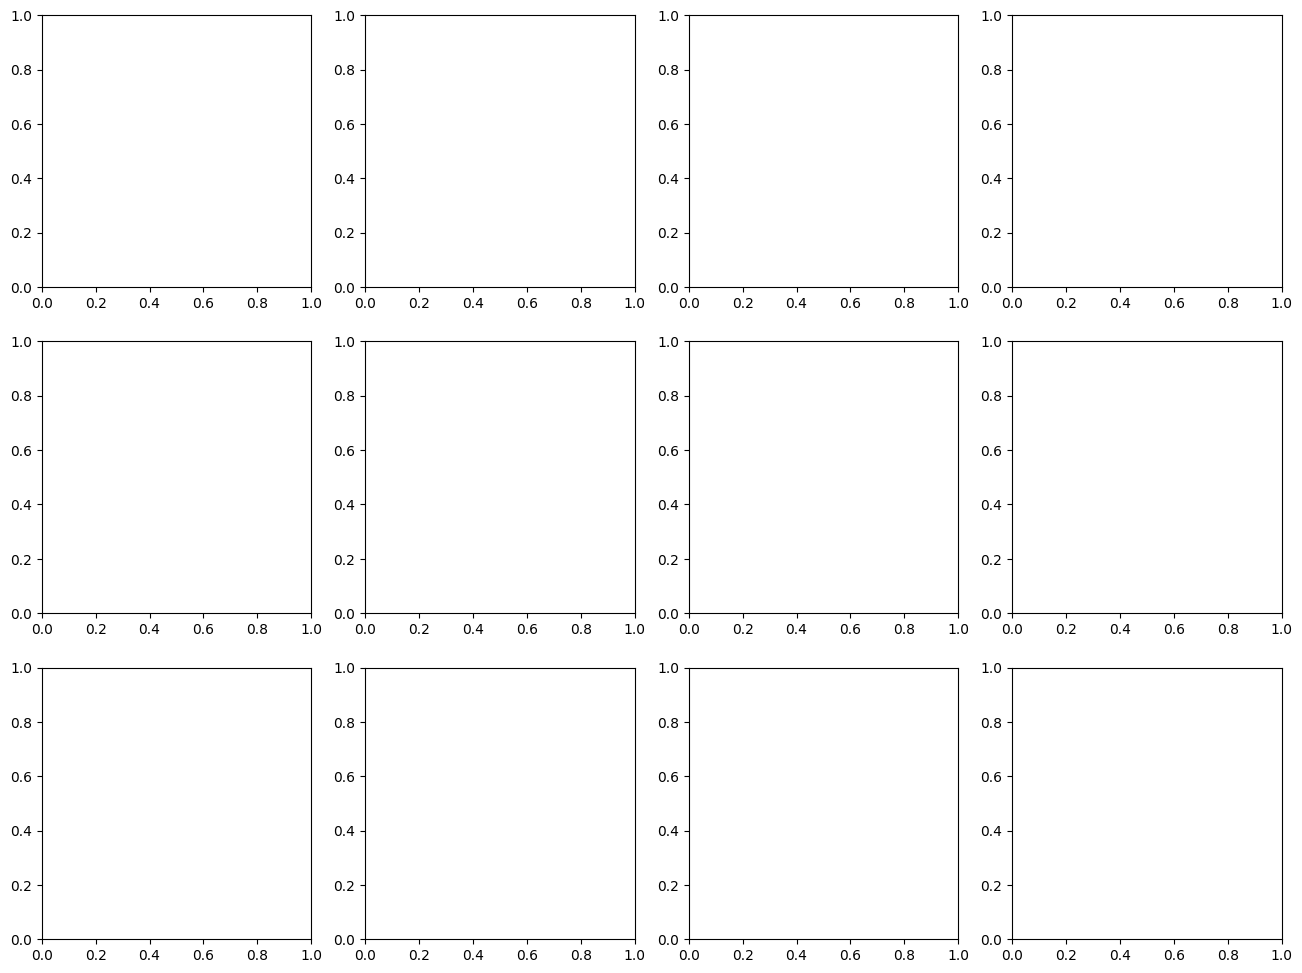

In [56]:
# ===================================================================
# SAMPLE PREDICTIONS VISUALIZATION
# ===================================================================

import random

# Get random samples from test set
num_samples = 12
test_files = []
test_labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TEST_DIR, class_name)
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for file in files[:4]:  # 4 samples per class
        test_files.append(file)
        test_labels.append(class_idx)

# Shuffle
combined = list(zip(test_files, test_labels))
random.shuffle(combined)
test_files, test_labels = zip(*combined)
test_files = list(test_files[:num_samples])
test_labels = list(test_labels[:num_samples])

# Create predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, (img_path, true_label) in enumerate(zip(test_files, test_labels)):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Apply preprocessing (CLAHE + ROI Masking)
    # For visualization, we apply without mask lookup (simplified)
    img_processed = apply_clahe_and_roi_masking(img_resized, mask_path=None)
    img_array = np.expand_dims(img_processed, axis=0)
    
    # Predict
    pred = best_model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]
    
    # Display
    axes[idx].imshow(img_resized)
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_class == true_label else 'red'
    title = f"True: {class_names[true_label].capitalize()}\n"
    title += f"Pred: {class_names[pred_class].capitalize()} ({confidence*100:.1f}%)"
    
    axes[idx].set_title(title, color=color, fontweight='bold', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set (CLAHE + ROI)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# FINAL SUMMARY REPORT
# ===================================================================

print("\n" + "="*80)
print("🎯 FINAL EVALUATION REPORT - DenseNet201 + ROI Masking Breast Cancer Classification")
print("="*80)

print("\n📁 Dataset Information:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Classes: {', '.join([c.capitalize() for c in class_names])}")

print("\n🏗️ Model Architecture:")
print(f"   Backbone: DenseNet201 (Pre-trained on ImageNet)")
print(f"   Custom Head: Fast Learning Network (FLN) + Improved Fusion")
print(f"   Hidden Neurons (FLN): {NEURONS_FLN}")
print(f"   Fusion Dense Layer: 256 neurons + BatchNorm")
print(f"   Dropout Rate (FLN): {DROPOUT_RATE}")
print(f"   Dropout Rate (Fusion): 0.5")

print("\n⚙️ Training Configuration:")
print(f"   Optimizer: Adam")
print(f"   Learning Rate (Initial): 0.001 (improved from 0.0001)")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs Trained: {len(history.history['accuracy'])}")
print(f"   Best Epoch: {best_epoch}")
print(f"   Class Weights: ✓ ENABLED (Balanced)")

print("\n🔬 Preprocessing:")
print(f"   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)")
print(f"   ROI Masking: ✓ (Region of Interest Extraction)")
print(f"   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)")

print("\n🛠️ Perbaikan untuk Mengatasi Majority Class Bias:")
print(f"   ✅ Class Weights: Mengatasi ketidakseimbangan data")
print(f"   ✅ Improved Head: Dense(256) + BatchNorm + Dropout(0.5)")
print(f"   ✅ Higher LR: 0.001 untuk head baru belajar lebih cepat")

print("\n📊 Test Set Performance:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (Weighted): {precision_avg:.4f}")
print(f"   Recall (Weighted): {recall_avg:.4f}")
print(f"   F1-Score (Weighted): {f1_avg:.4f}")

print("\n📈 Per-Class F1-Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {f1[i]:.4f}")

print("\n🎯 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {roc_auc[i]:.4f}")

# Cek apakah masih ada bias ke satu kelas
print("\n🔍 Bias Check:")
test_pred_distribution = [np.sum(predicted_classes == i) for i in range(NUM_CLASSES)]
max_pred_class = np.argmax(test_pred_distribution)
max_pred_percentage = (test_pred_distribution[max_pred_class] / len(predicted_classes)) * 100

if max_pred_percentage > 80:
    print(f"   ⚠️  WARNING: {max_pred_percentage:.1f}% prediksi adalah {class_names[max_pred_class].capitalize()}")
    print(f"      Model mungkin masih bias ke kelas mayoritas!")
elif max_pred_percentage > 60:
    print(f"   ⚠️  MODERATE: {max_pred_percentage:.1f}% prediksi adalah {class_names[max_pred_class].capitalize()}")
    print(f"      Ada sedikit bias, pertimbangkan fine-tuning lebih lanjut")
else:
    print(f"   ✅ BAGUS: Distribusi prediksi cukup seimbang")
    print(f"      Prediksi tertinggi: {class_names[max_pred_class].capitalize()} ({max_pred_percentage:.1f}%)")

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)


🎯 FINAL EVALUATION REPORT - DenseNet201 + ROI Masking Breast Cancer Classification

📁 Dataset Information:
   Training samples: 824
   Validation samples: 113
   Test samples: 93
   Classes: Benign, Malignant, Normal

🏗️ Model Architecture:
   Backbone: DenseNet201 (Pre-trained on ImageNet)
   Custom Head: Fast Learning Network (FLN)
   Hidden Neurons: 471
   Dropout Rate: 0.44

⚙️ Training Configuration:
   Optimizer: Adam
   Learning Rate: 0.000506
   Batch Size: 16
   Epochs Trained: 18
   Best Epoch: 8

🔬 Preprocessing:
   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)
   ROI Masking: ✓ (Region of Interest Extraction)
   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)

📊 Test Set Performance:
   Accuracy: 0.7634 (76.34%)
   Precision (Weighted): 0.7935
   Recall (Weighted): 0.7634
   F1-Score (Weighted): 0.7489

📈 Per-Class F1-Scores:
   Benign: 0.7755
   Malignant: 0.8169
   Normal: 0.4706

🎯 AUC Scores:
   Benign: 0.8766
   Malignant: 0.9342
   Normal: 0.8885

✅ 

In [ ]:
# ===================================================================
# VISUALISASI CONTOH PREPROCESSING (CLAHE + ROI Masking)
# ===================================================================

def visualize_preprocessing_with_mask(img_path, class_name, split='test'):
    """
    Visualisasi proses preprocessing: Original -> CLAHE -> ROI Masked
    """
    # Load original image
    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (IMG_WIDTH, IMG_HEIGHT))
    
    # Get filename
    filename = os.path.basename(img_path)
    
    # Find corresponding mask
    mask_path = find_mask_path(filename, class_name, split)
    
    # Apply CLAHE only
    img_clahe = apply_clahe_and_roi_masking(img_original.copy(), mask_path=None)
    
    # Apply CLAHE + ROI Masking
    img_masked = apply_clahe_and_roi_masking(img_original.copy(), mask_path=mask_path)
    
    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].imshow(img_original)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Mask (if exists)
    if mask_path and os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('ROI Mask', fontsize=12, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, 'No Mask Available', ha='center', va='center', fontsize=12)
        axes[1].set_title('ROI Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # CLAHE only (need to denormalize for visualization)
    # Since preprocess_input changes range, we show original with CLAHE
    img_clahe_viz = img_original.copy().astype('uint8')
    lab = cv2.cvtColor(img_clahe_viz, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img_clahe_viz = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    axes[2].imshow(img_clahe_viz)
    axes[2].set_title('After CLAHE', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # CLAHE + ROI (visualize the masked region)
    if mask_path and os.path.exists(mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask_3ch = cv2.merge([mask_binary, mask_binary, mask_binary])
        img_roi_viz = cv2.bitwise_and(img_clahe_viz, mask_3ch)
        axes[3].imshow(img_roi_viz)
        axes[3].set_title('After CLAHE + ROI Masking', fontsize=12, fontweight='bold')
    else:
        axes[3].imshow(img_clahe_viz)
        axes[3].set_title('After CLAHE (No Mask)', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    plt.suptitle(f'Preprocessing Pipeline: {filename}\nClass: {class_name.capitalize()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage - uncomment and provide actual image path
# visualize_preprocessing_with_mask(
#     "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan\\test\\benign\\benign (201).png",
#     "benign",
#     "test"
# )

print("\n✅ Visualization function ready!")
print("   Use: visualize_preprocessing_with_mask(img_path, class_name, split)")
print("   Example: visualize_preprocessing_with_mask('path/to/image.png', 'benign', 'test')")


✅ Visualization function ready!
   Use: visualize_preprocessing_with_mask(img_path, class_name, split)
   Example: visualize_preprocessing_with_mask('path/to/image.png', 'benign', 'test')
